<a href="https://colab.research.google.com/github/nafizahamed8/Artificial-Intelligence-repo/blob/main/Hate_Speech_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import neccesary Libraries
import pandas as pd
from sklearn.utils import resample
from matplotlib import pyplot as plt
import seaborn as sns
!pip install bangla-stemmer
from bangla_stemmer.stemmer import stemmer
from collections import Counter
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.keras.models import Sequential # Import the Sequential class
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import numpy as np



Mounting Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# df = pd.read_csv("/content/drive/MyDrive/final_merged_dataset_no_duplicates.csv")

In [ ]:
# Load your dataset
import pandas as pd
import io
import requests

# Update the URL to the raw CSV data
url = "https://raw.githubusercontent.com/Mahbubur-Rahman-15/Hate-Speech-Dataset/main/final_merged_dataset_no_duplicates.csv"
response = requests.get(url)
response.raise_for_status()  # Raise an exception if the request fails

# Read the CSV content into a Pandas DataFrame
df = pd.read_csv(io.StringIO(response.text))

Data Sampling

In [ ]:
# prompt: take 1/40 data from df

fraction = 0.025 # 1/40 = 0.025
df_sample = df.sample(frac=fraction, random_state=42) # random_state for reproducibility
df_sample.shape

(884, 2)

In [ ]:
print(df_sample['label'].value_counts())

label
general         449
Religious       106
Geopolitical     84
Personal         83
gender           67
Political        52
sports           38
Sexual            4
Threat            1
Name: count, dtype: int64


In [ ]:
df = df_sample
# Remove rows where the 'label' column is 'SEXUAL' or 'THREAT'
df = df[~df['label'].isin(['Sexual', 'Threat'])]


In [ ]:
df.shape
print(df['label'].value_counts())

label
general         449
Religious       106
Geopolitical     84
Personal         83
gender           67
Political        52
sports           38
Name: count, dtype: int64


In [ ]:
# Separate classes
dfs = []
for class_label in df['label'].unique():
    dfs.append(df[df['label'] == class_label])

# Upsample minority classes
max_size = max([len(df_c) for df_c in dfs])
upsampled_dfs = []
for df_c in dfs:
    upsampled_dfs.append(resample(df_c, replace=True, n_samples=max_size, random_state=42))

# Combine upsampled classes
df_balanced = pd.concat(upsampled_dfs)
print(df_balanced['label'].value_counts())

label
Geopolitical    449
Personal        449
gender          449
general         449
Religious       449
sports          449
Political       449
Name: count, dtype: int64


In [ ]:
print(df_balanced.sample(5))

                                                    text      label
1981                             মাদারি মাহি তুই কি ভদ্র  Political
18377                                  পপির যৌবন ভরা দেহ     gender
6870   আব্বুর হাতে মাইর খাওয়ার পর আমার অবস্থা, আর আব্...   Personal
9061       সালারপুতেরে জুরে একটা থাপ্পড় মারতে পারতাম😠😠😠😠     sports
31336  এটা ফরিদপুরে ঘটনা ৷ এই সালা ইউটিঊবাররে সবাই জূ...    general


In [ ]:
df_balanced.shape

(3143, 2)

In [ ]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3143 entries, 3808 to 15854
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3143 non-null   object
 1   label   3143 non-null   object
dtypes: object(2)
memory usage: 73.7+ KB


In [ ]:
df_balanced.head()

,text,label
3808,মাদারচোদ ও আই সি কি করছে মুসলিম দেশগুলোর সংস্...,Geopolitical
3349,বিপুল পরিমান অস্ত্র ভারত সাথে করে নিয়ে গেছে,Geopolitical
1483,ভারতে যখন ট্রেন দূর্ঘটনা ঘটছে তকন হাসিনা দুঃখ ...,Geopolitical
5514,ভারত গরুর দেশ গিয়ে লাভ নাই,Geopolitical
35305,হিন্দুগুলার এতো জলে কেন ???? যখন রেন্ডিয়াতে মু...,Geopolitical


In [ ]:
df_balanced.tail()

,text,label
7387,একদম ঠিক বলছে মূর্খ নেত্রী খালেদা জিয়াকে দেখত...,Political
15661,আমি মেঘনা ব্রীজ দেখেছি । রাঙামাটির ঝুলন্ত ব্রী...,Political
15214,ওবায়দুল কাদেরের জাঙ্গিয়ার দাম মনে হয় লাখ টাকা ...,Political
7708,লে: কর্নেল জাফর এখানে এত উগ্র একে ভালো করে গাঁ...,Political
15854,এই নুরু শুয়ারের বাচ্চা পাগল নাকি একেক বার একেক...,Political


In [ ]:
for label in df_balanced['label'].unique():
    print(label)

Geopolitical
Personal
gender
general
Religious
sports
Political


In [ ]:
label_counts = df_balanced['label'].value_counts()

for label, count in label_counts.items():
    print(f"{label}: {count}")

Geopolitical: 449
Personal: 449
gender: 449
general: 449
Religious: 449
sports: 449
Political: 449


In [ ]:
from sklearn.model_selection import train_test_split
train_data, remaining_data = train_test_split(df_balanced, test_size=0.3, random_state=42)
test_data, validation_data = train_test_split(remaining_data, test_size=0.33, random_state=42)

In [ ]:
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Validation data shape: {validation_data.shape}")

Train data shape: (2200, 2)
Test data shape: (631, 2)
Validation data shape: (312, 2)


In [ ]:
train_data['count'] = train_data['text'].str.split().str.len()
test_data['count'] = test_data['text'].str.split().str.len()
validation_data['count'] = validation_data['text'].str.split().str.len()
display(train_data)
train_data.head()
train_data.describe()
train_data.info()

,text,label,count
3806,বৌদি কার হাতের ছোঁয়াতে তোমার ওগুলো এত বড় হলো ?,Personal,10
8296,পাপনকে জুতা এরে ধরে না কে বঝলাম না এটাই কি ক্ষ...,sports,15
9423,জুতা মারি তার গালে পাপন তো একটা মাদার চোদ,sports,9
15854,এই নুরু শুয়ারের বাচ্চা পাগল নাকি একেক বার একেক...,Political,11
9545,তর মায়েরে সালা চোর তর মাইরে সালা চোর চোর চোর চ...,sports,29
...,...,...,...
896,যুবলীগ মানেই হচ্ছে সরকারের গোলামী করার জন্য,Political,7
24615,এ মাগিরে ঘোড়া দিয়ে চোদানো উচিত আর ওর মাকে কু...,gender,13
24390,যারা মতিয়া চৌধুরীর রাজাকার শব্দকে ব্যাখ্যা দিচ...,gender,40
23901,দুধ গুলা বের করা রাখা ঐ ভাব,gender,7


<class 'pandas.core.frame.DataFrame'>
Index: 2200 entries, 3806 to 6176
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2200 non-null   object
 1   label   2200 non-null   object
 2   count   2200 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 68.8+ KB


Plotting DataSample

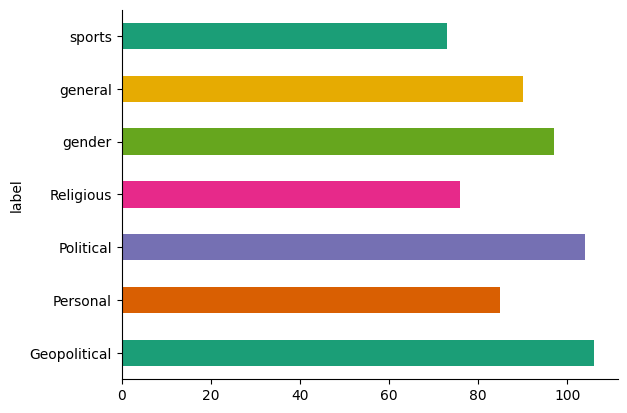

In [ ]:
test_data.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

StopWord Removing

In [ ]:
def stopwordRemoval(text):
  x=str(text)
  l=x.split()

  stm=[elem for elem in l if elem not in stop]

  out=' '.join(stm)

  return str(out)

In [ ]:
data=pd.read_excel('/content/drive/MyDrive/bangla_stopwords.xlsx')
display(data)

,Unnamed: 0,word_list
0,0,অই
1,1,অগত্যা
2,2,অত: পর
3,3,অতএব
4,4,অথচ
...,...,...
727,727,হয়েই
728,728,হয়েছিল
729,729,হয়েছে
730,730,হয়েছেন


Stemming

In [ ]:
#importing stemmer
!pip install bangla-stemmer
from bangla_stemmer.stemmer import stemmer

In [ ]:
## stemmer function
def stem_text (x):
  stmr = stemmer.BanglaStemmer()
  words=x.split(' ')
  stm = stmr.stem(words)
  words=(' ').join(stm)
  return words

In [ ]:
train_data['text']=train_data['text'].apply(stem_text)
test_data['text']=test_data['text'].apply(stem_text)
validation_data['text']=validation_data['text'].apply(stem_text)

Streaming output truncated to the last 5000 lines.
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied f

Labeling Numbers

In [ ]:
#changing label to numbers
train_data['label'].replace({'general':'0','gender':'1','Religious':'2','Political':'3','Personal':'4','Geopolitical':'5','sports':'6'},inplace=True)
test_data['label'].replace({'general':'0','gender':'1','Religious':'2','Political':'3','Personal':'4','Geopolitical':'5','sports':'6'},inplace=True)
validation_data['label'].replace({'general':'0','gender':'1','Religious':'2','Political':'3','Personal':'4','Geopolitical':'5','sports':'6'},inplace=True)


<ipython-input-27-4ea1f1bb167c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['label'].replace({'general':'0','gender':'1','Religious':'2','Political':'3','Personal':'4','Geopolitical':'5','sports':'6'},inplace=True)
<ipython-input-27-4ea1f1bb167c>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

In [ ]:
train_data.head()

,text,label,count
3806,বৌদি কার হাত ছোঁয়া তোম ওই এত বড় হলো ?,4,10
8296,পাপন জুতা এরে ধরে না কে বঝ না এটা কি ক্ষমত দাপ...,6,15
9423,জুতা মারি তার গালে পাপন তো এক মাদা চোদ,6,9
15854,এই নুরু শুয়ার বাচ্চা পাগল নাকি একেক বার একেক ক...,3,11
9545,তর মায়ের সালা চোর তর মাইরে সালা চোর চোর চোর চো...,6,29


In [ ]:
test_data.head()

,text,label,count
18649,দুদ গুল দাএ কাত,1,4
8928,মাগির পুলামাল খাই আবাল মত ভুল বাল বকিশ,6,8
24242,মাগির দুদ গুলা,1,3
20168,কিছু খানখি পোলা খানখী মাগির করনে দেশ টা খারাব ...,1,11
7609,ভাই সরক দোষ দিব না সরকার কারণে আপনা এখনো মায় ক...,5,27


In [ ]:
train_data=train_data.dropna()
test_data=test_data.dropna()
validation_data=validation_data.dropna()

Counting Text Length

In [ ]:
#counting text length
train_data['count']=train_data['text'].str.split().str.len()
test_data['count']=test_data['text'].str.split().str.len()
validation_data['count']=validation_data['text'].str.split().str.len()

In [ ]:
train_sentences=train_data['text'].values
train_labels=train_data['label'].values

In [ ]:
test_sentences=test_data['text'].values
test_labels=test_data['label'].values

In [ ]:
validation_sentences=validation_data['text'].values
validation_labels=validation_data['label'].values

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical


num_classes = 7  # Set the number of classes to 7
# One-hot encode train_labels with 7 classes
train_labels = to_categorical(train_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

In [ ]:
print("Training Set Length: "+str(len(train_data)))
print("Testing Set Length: "+str(len(test_data)))
print("Validation Set Length: "+str(len(validation_data)))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))
print("validation_labels shape: "+str(validation_labels.shape))

Training Set Length: 2200
Testing Set Length: 631
Validation Set Length: 312
train_labels shape: (2200, 7)
test_labels shape: (631, 7)
validation_labels shape: (312, 7)


In [ ]:
for sentence in train_sentences:
  print(sentence)

বৌদি কার হাত ছোঁয়া তোম ওই এত বড় হলো ?
পাপন জুতা এরে ধরে না কে বঝ না এটা কি ক্ষমত দাপটওকে কে চিনে সালা
জুতা মারি তার গালে পাপন তো এক মাদা চোদ
এই নুরু শুয়ার বাচ্চা পাগল নাকি একেক বার একেক কথা বলে
তর মায়ের সালা চোর তর মাইরে সালা চোর চোর চোর চোর চোর চোর চোর চোর চোর চোর চোর চোর চোর চোর চোর চোর চোর চোর চোর চোর চোর চোর
পারে না কথা বল এর আব উপস্থাপনা করে
মাগীর কি এটি দুধ না অন্য কিছু চার জন দাখ হাট ফিল কর
এক তীর ধনুক থাকলে হোগ উপর মার দেখা দিতাম অর্জুন কাক বলে
মুর্খ আবাল
ছাএলীগ নাম শুনলে মনে হয় নাম গা মুত দেই
এইসব চোদমারানির পোলা এত পচানি খায় তাও শিক্ষা হয় না
বার কাপ আন পারে নাই কোটি খেলা ওপহ আর লাখ মাসিক বেতন তারপরে ও এত দাবি আর এত ডিমান্ড সালা প্লেয়ার লাঠি মার বাহির করে দাওয়া উচিৎ।
এই মহিলা কাফ শয়তান। ওলিপুরির নাজায়েজ গার্লফ্রেন্ড
জানোয় কে কুত্ত মত পেটাতাম যদি সামনে পেতাম
বাল পাকনা ভালো  এত বেশি বাল পাকনা ভালো না
কিরে ফকিরন্নির পুত।তোর জন্ম ঠিক আছে।সালা হারামজাদা
আরে মাগী তোর জিন তো সবা দাখ তোর আর বাচ লাভ কি
কিরে ফকিরন্নির পুত।তোর জন্ম ঠিক আছে।সালা হারামজাদা
ভারত সব হিন্দু গরু বিয়ে করাব হিন

Vocabulary Size and Maximum Sequence Length

In [ ]:
from collections import Counter

# Combine all sentences from train, test, and validation sets
all_sentences = train_sentences.tolist() + test_sentences.tolist() + validation_sentences.tolist()

# Tokenize all sentences
all_words = [word for sentence in all_sentences for word in sentence.split()]

# Count word frequencies
word_counts = Counter(all_words)

# Vocab size is the number of unique words
vocab_size = len(word_counts)

print(f"Vocab size: {vocab_size}")

Vocab size: 3577


In [ ]:
import numpy as np

# Combine all sentences from train, test, and validation sets
all_sentences = np.concatenate([train_sentences, test_sentences, validation_sentences])

# Calculate sentence lengths
sentence_lengths = [len(sentence.split()) for sentence in all_sentences]

# Calculate percentiles
percentile_95 = int(np.percentile(sentence_lengths, 95))
percentile_99 = int(np.percentile(sentence_lengths, 99))

print(f"95th percentile of sentence lengths: {percentile_95}")
print(f"99th percentile of sentence lengths: {percentile_99}")

# Choose max_length based on percentiles
max_length = percentile_95  # or percentile_99, depending on your preference
print(f"Chosen max_length: {max_length}")

95th percentile of sentence lengths: 40
99th percentile of sentence lengths: 81
Chosen max_length: 40


In [ ]:
vocab_size=3577
embedding_dim=64
max_length=40
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
print(train_sentences.shape)
print(train_labels.shape)

(2200,)
(2200, 7)


Tokenization

In [ ]:
#tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

In [ ]:
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))

3270
Word index length:3270


Padding

In [ ]:
from tensorflow.keras.utils import pad_sequences
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

In [ ]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (2200, 40)
Padded shape(testing): (631, 40)


In [ ]:
from tensorflow.keras.utils import pad_sequences
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

In [ ]:
print("Sentence :--> \n")
print(train_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length:--> \n")
print(padded[2])

Sentence :--> 

জুতা মারি তার গালে পাপন তো এক মাদা চোদ

Sentence Tokenized and Converted into Sequence :--> 

[74, 340, 30, 277, 40, 14, 8, 83, 81]

After Padding the Sequence with padding length:--> 

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  74 340  30 277  40
  14   8  83  81]


In [ ]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Model Training

In [ ]:
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.keras.models import Sequential # Import the Sequential class
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [ ]:
model= Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(16, return_sequences=True)))
#l2 regularizer
model.add(Dense(16,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
model.add(Flatten())
model.add(Dense(7, activation='softmax'))
#sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history=model.fit(padded,train_labels,epochs=10,batch_size=32,validation_data=( validation_padded,validation_labels))

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.2203 - loss: 2.1385 - val_accuracy: 0.1955 - val_loss: 2.0591
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3917 - loss: 1.9588 - val_accuracy: 0.6122 - val_loss: 1.3562
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7336 - loss: 1.1118 - val_accuracy: 0.8494 - val_loss: 0.7695
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9069 - loss: 0.5119 - val_accuracy: 0.9135 - val_loss: 0.4571
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9797 - loss: 0.2602 - val_accuracy: 0.9391 - val_loss: 0.4004
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9911 - loss: 0.1945 - val_accuracy: 0.9263 - val_loss: 0.4628
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9898 - loss: 0.1911 - val_accuracy: 0.9391 - val_loss: 0.4148
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9925 - loss: 0.1668 - val_accuracy: 0.9455 - v

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 40, 64)              │         228,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 40, 32)              │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 40, 16)              │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           4,487 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 732,935 (2.80 MB)

 Trainable params: 244,311 (954.34 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 488,624 (1.86 MB)

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


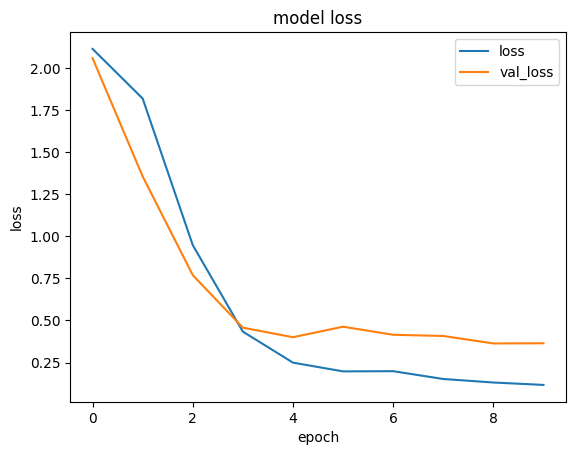

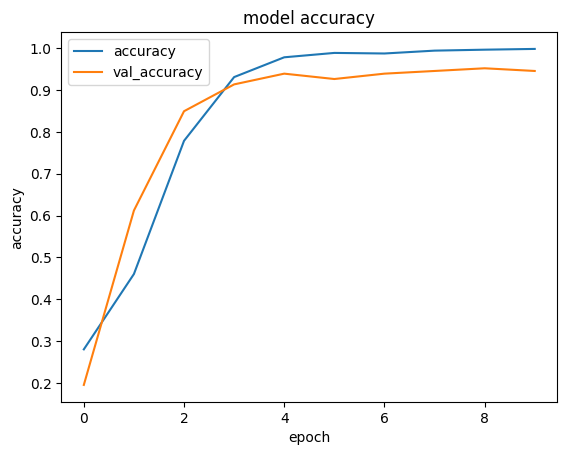

In [ ]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=64)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=64)
print("The test accuracy is: "+str(loss_and_metrics[1]))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9965 - loss: 0.1118
The train accuracy is: 0.9968181848526001
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9247 - loss: 0.4784
The test accuracy is: 0.9397781491279602


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


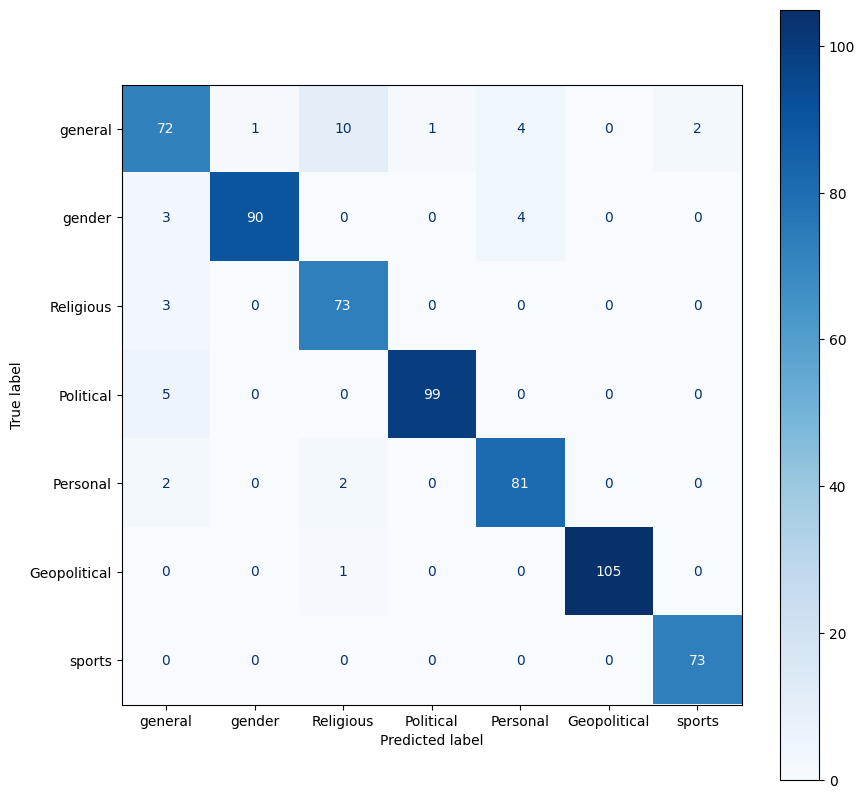

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt
import numpy as np



# Predict on the test data
y_pred = model.predict(testing_padded)

# Convert predictions and true labels to class indices
predicted_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)


fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figsize as needed



disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['general','gender','Religious','Political','Personal','Geopolitical','sports'])

# Pass the axes to the plot method
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

In [ ]:
# Print classification report with precision, recall, F1-score
print(classification_report(true_classes, predicted_classes, target_names=['general','gender','Religious','Political','Personal','Geopolitical','sports']))

              precision    recall  f1-score   support

     general       0.85      0.80      0.82        90
      gender       0.99      0.93      0.96        97
   Religious       0.85      0.96      0.90        76
   Political       0.99      0.95      0.97       104
    Personal       0.91      0.95      0.93        85
Geopolitical       1.00      0.99      1.00       106
      sports       0.97      1.00      0.99        73

    accuracy                           0.94       631
   macro avg       0.94      0.94      0.94       631
weighted avg       0.94      0.94      0.94       631

